# Adding mock observational effects to lightcones

In this notebook, we show how to add mock observational effects to lightcones.
Note that this time, only "rectilinear" lightcones are supported, i.e. lightcones
for which at each redshift slice they are defined at a set comoving grid.

Support for other kinds of lightcones may be added in the future.

The methods here don't make approximations when it comes to getting the noise per UV-cell: the UV cell sizes are computed correctly at 
each redshift given the assumption of a constant comoving box size. 

The only approximations that are made are when removing the wedge. The wedge cannot be calculated exactly since it is redshift-dependent. 
So there we provide two methods, each of which looks at a smaller chunk of redshift at a time. We compare these two methods below.

**TODO**

- Support for other lightcone kinds
- Beam tapering

In [1]:
import numpy as np
from py21cmsense import Observatory, Observation
from py21cmsense.conversions import z2f, f2z
import astropy.units as un
from astropy.cosmology import Planck18, z_at_value
import powerbox
from tuesday.core import compute_thermal_rms_uvgrid
from py21cmsense.baseline_filters import BaselineRange
from tuesday.core import sample_from_rms_uvgrid, observe_lightcone

import matplotlib.pyplot as plt

# Set observation parameters
We choose the SKA layout and set the number of tracking hours. 
Since the goal is to create a lightcone realisation from SKA, the observation frequencies should be chosen according to the frequencies / redshifts of the lightcone.

In [2]:
observatory = Observatory.from_ska("LOW_FULL_AA4")

# Define an observation
obs = Observation(
    observatory=observatory, 
    lst_bin_size=2 * un.hour,
    integration_time=300*un.s,
    bandwidth=50 *un.kHz,
    n_days=180,  # about one year while galaxy is down.
    baseline_filters= BaselineRange(bl_min=10.*un.m,bl_max=2000.*un.m),
)

/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/abc.py:106: FutureWarning: xarray subclass Visibility should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


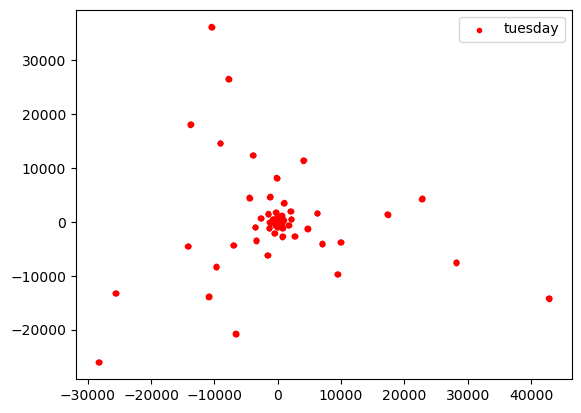

In [3]:
plt.scatter(observatory.antpos[:,0], observatory.antpos[:,1], color = "r", marker = ".", label = "tuesday")
plt.legend()
plt.show()


# Calculating thermal noise in uv space with `tuesday`
With `tuesday`, the user can use the `Observatory` object along with the integration time and daily observation duration to define an `Observation`. 
Here you can optionally set the minimum and/or maximum baselines as well.

In [4]:
# Setup some fake frequencies, similar to a standard observation,
# but regular in comoving distance, like a typical simulation.
#lc_freqs = np.linspace(110, 125, 151) * un.MHz
#lc_redshifts = f2z(lc_freqs)

boxlength = 300. *un.Mpc
box_ncell = 200
box_res = boxlength / box_ncell

min_freq = 110 * un.MHz
max_freq = 122 * un.MHz # 12 MHz spectral window, say.
min_z = f2z(max_freq)
max_z = f2z(min_freq)

min_dist = Planck18.comoving_distance(min_z)
max_dist = Planck18.comoving_distance(max_z)

distances = np.arange(min_dist.to_value("Mpc"), max_dist.to_value("Mpc"), box_res.to_value("Mpc")) * un.Mpc
nz = len(distances)

lc_redshifts = np.array([z_at_value(Planck18.comoving_distance, d) for d in distances])
lc_freqs = z2f(lc_redshifts)

lc_shape = (box_ncell, box_ncell, nz)

In [5]:
print(f"Lightcone shape: {lc_shape}")

Lightcone shape: (200, 200, 157)


## Compute thermal noise RMS

In [6]:
ugrid_edges, sigma_uv, uv_coverage = compute_thermal_rms_uvgrid(
    observation=obs,
    freqs=lc_freqs,
    box_length=boxlength,
    box_ncells=lc_shape[0],
    min_nbls_per_uv_cell=15
)

/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
finding redundancies:   0%|          | 0/511 [00:00<?, ?ants/s]/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects

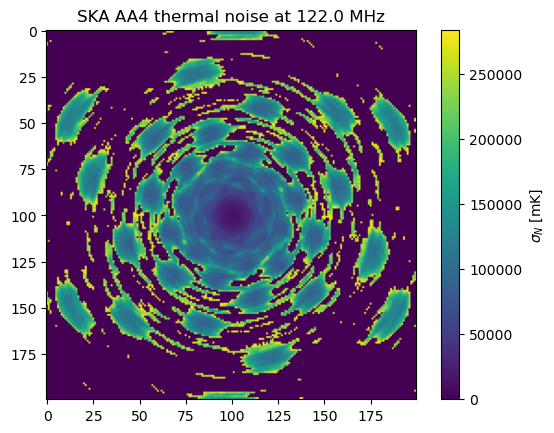

In [7]:
im = plt.imshow(sigma_uv[...,0].value)
plt.colorbar(im, label=r"$\sigma_{N}$ [mK]")
plt.title(f"SKA AA4 thermal noise at {np.round(lc_freqs[0].to_value('MHz'),1)} MHz")
plt.show()

# Sample lightcone noise with `tuesday`
With `tuesday` we can control the random generation by setting a random seed manually for reproducibility. If not set, a seed is chosen at random.\
We can also set the number of noise realisations we want with `nsamples`.\
`sample_from_rms_noise` takes as input the thermal noise in uv space that we plotted above and returns only samples of the noise in real or Fourier space.
On the other hand, the `sample_lc_noise` convenience function does the entire noise calculation given an `Observation` and a `lightcone` and returns samples of noisy lightcones, where realisations of thermal noise have been added in Fourier space as in Prelogovic+23.

In [8]:
lc_noise = sample_from_rms_uvgrid(
    rms_noise=sigma_uv,
    seed=4, 
    nsamples=3,
)

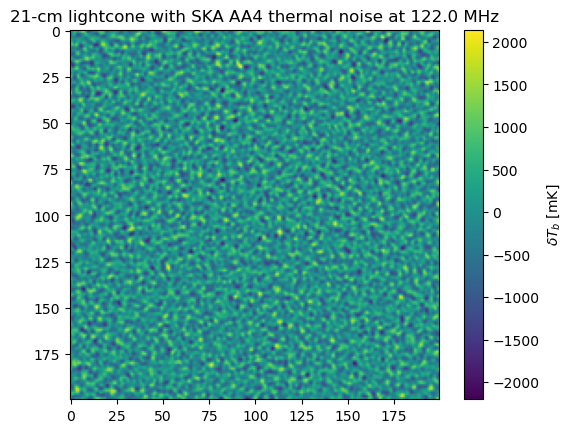

In [9]:
im = plt.imshow(lc_noise[0,...,150].real.value)
plt.colorbar(im, label=r"$\delta T_b$ [mK]")
plt.title(f"21-cm lightcone with SKA AA4 thermal noise at {np.round(lc_freqs[0].to_value('MHz'),1)} MHz")
plt.show()

## Mock-Observation of a Lightcone

To add "observational effects" to an existing lightcone, use the `observe_lightcone` function. This will add an appropriate amount of thermal noise, as well as optinally removing k-modes in the foreground wedge:

In [10]:
lightcone = np.zeros(sigma_uv.shape) * un.mK

lc_with_noise, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=4,
    nsamples=3,
    remove_wedge=False
)    

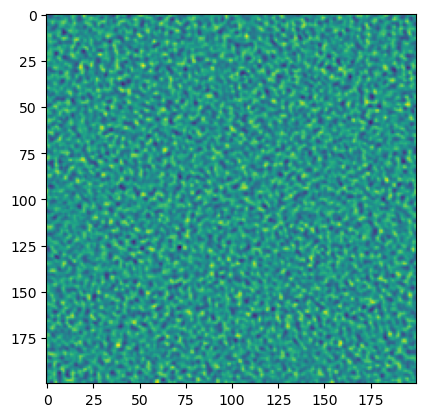

In [11]:
plt.imshow(lc_with_noise[0,:, :, 0].value)
           

We could also remove the foreground wedge. To set the slope of the wedge, use the `wedge_slope` argument (1.0 is the horizon limit):

In [12]:
lc_with_noise_wedge_removed, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=4,
    nsamples=3,
    remove_wedge=True,
    wedge_slope=1.0
)    

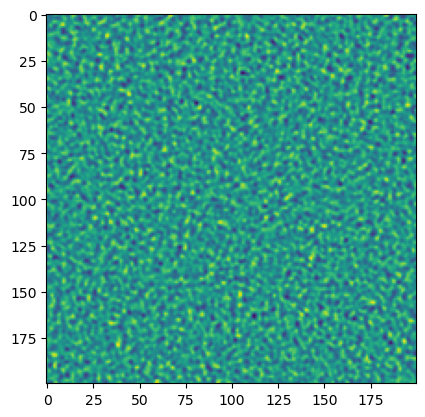

In [13]:
plt.imshow(lc_with_noise_wedge_removed[0,:, :, 0].value)

Text(0.5, 1.0, '+ Wedge Removed')

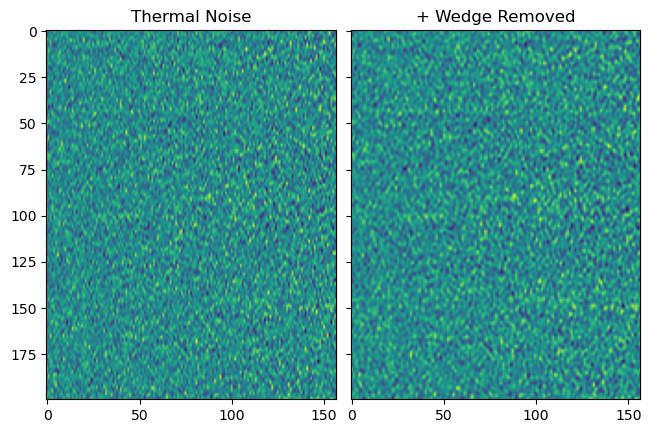

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)

ax[0].imshow(lc_with_noise[0, 0].value)
ax[0].set_title("Thermal Noise")

ax[1].imshow(lc_with_noise_wedge_removed[0, 0].value)
ax[1].set_title("+ Wedge Removed")

We can make sure that setting the wedge_slope to zero gives us the same thing as not removing any wedge at all:

In [15]:
lc_with_noise_zero_wedge, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=4,
    nsamples=3,
    remove_wedge=True,
    wedge_slope=0.0
)    

In [16]:
print("Total difference between no wedge and zero wedge (should be zero): ", np.sum(lc_with_noise_zero_wedge - lc_with_noise))

Total difference between no wedge and zero wedge (should be zero):  -4.473577064345591e-10 mK


We can also remove an extra buffer if we wish (specify the buffer in nanoseconds, as it is a delay):

In [17]:
lc_with_noise_buffer, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=4,
    nsamples=3,
    remove_wedge=True,
    wedge_slope=1.0,
    wedge_buffer=300*un.ns
)    

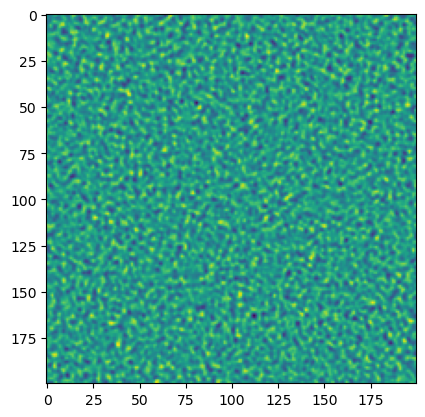

In [18]:
plt.imshow(lc_with_noise_buffer[0,:, :, 0].value)

Text(0.5, 1.0, '+ Buffer Removed')

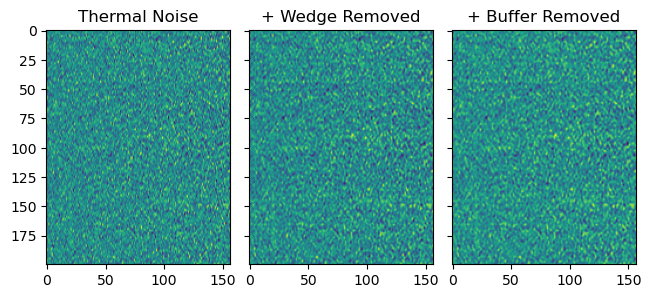

In [19]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True)

ax[0].imshow(lc_with_noise[0, 0].value)
ax[0].set_title("Thermal Noise")

ax[1].imshow(lc_with_noise_wedge_removed[0, 0].value)
ax[1].set_title("+ Wedge Removed")

ax[2].imshow(lc_with_noise_buffer[0, 0].value)
ax[2].set_title("+ Buffer Removed")


Finally, just to be sure that things are working as expected, let's set the slope much higher than the horizon. 
For example, let's set it to 25, which should remove many many modes:

In [20]:
lc_with_large_wedge, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=4,
    nsamples=3,
    remove_wedge=True,
    wedge_slope=25.0,
    #wedge_buffer=300*un.ns
)    

Text(0.5, 1.0, 'Large Wedge')

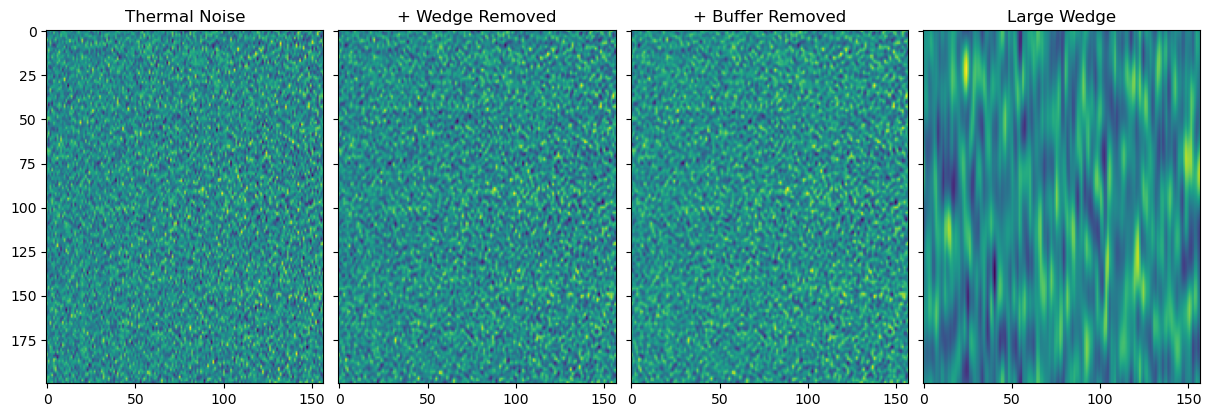

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

ax[0].imshow(lc_with_noise[0, 0].value)
ax[0].set_title("Thermal Noise")

ax[1].imshow(lc_with_noise_wedge_removed[0, 0].value)
ax[1].set_title("+ Wedge Removed")

ax[2].imshow(lc_with_noise_buffer[0, 0].value)
ax[2].set_title("+ Buffer Removed")

ax[3].imshow(lc_with_large_wedge[0, 0].value)
ax[3].set_title("Large Wedge")


Similarly, we could remove a very large buffer. In this case, the frequency resolution is:

In [22]:
dnu = (lc_freqs[0] - lc_freqs[1]).to("MHz")
print(dnu)

0.07875906804614974 MHz


This corresponds to a delay of:

In [23]:
(1/dnu).to('ns')

<Quantity 12696.95064718 ns>

In [24]:
lc_with_large_buffer, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=4,
    nsamples=3,
    remove_wedge=True,
    wedge_slope=0.0,
    wedge_buffer=6500*un.ns,
)    

Text(0.5, 1.0, 'Large Buffer')

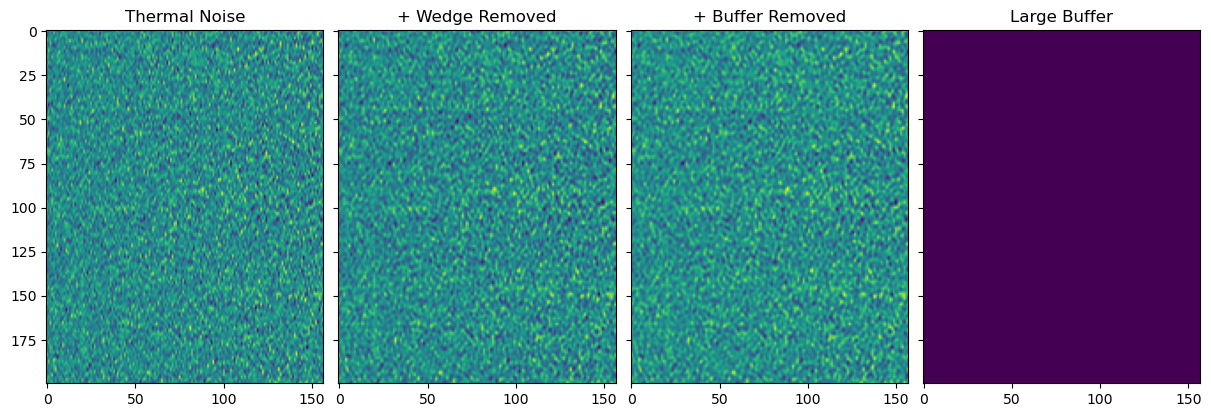

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

ax[0].imshow(lc_with_noise[0, 0].value)
ax[0].set_title("Thermal Noise")

ax[1].imshow(lc_with_noise_wedge_removed[0, 0].value)
ax[1].set_title("+ Wedge Removed")

ax[2].imshow(lc_with_noise_buffer[0, 0].value)
ax[2].set_title("+ Buffer Removed")

ax[3].imshow(lc_with_large_buffer[0, 0].value)
ax[3].set_title("Large Buffer")

As expected, we've removed all the modes!

## Comparing wedge-removal techniques

So far, we've been using the default wedge-removal technique, which is to define the `kperp` modes in chunks of the lightcone, and by default the chunk size is the entire lightcone. In this case, this is a decent option, since the lightcone was constructed to be about the size of a normal spectral window (i.e. the coordinates don't evolve too much over the lightcone). 

Another technique for wedge-removal is to "roll" the window. Here we compare these techniques, for a slightly longer lightcone (so we can roll the window for each).

In [26]:
boxlength = 172. *un.Mpc
box_ncell = 128

box_res = boxlength / box_ncell

min_freq = 110 * un.MHz
max_freq = 134 * un.MHz # 2*12 MHz spectral windows, say.
min_z = f2z(max_freq)
max_z = f2z(min_freq)

min_dist = Planck18.comoving_distance(min_z)
max_dist = Planck18.comoving_distance(max_z)

distances = np.arange(min_dist.to_value("Mpc"), max_dist.to_value("Mpc"), box_res.to_value("Mpc")) * un.Mpc
nz = len(distances)

lc_redshifts = np.array([z_at_value(Planck18.comoving_distance, d) for d in distances])
lc_freqs = z2f(lc_redshifts)

lc_shape = (box_ncell, box_ncell, nz)

In [27]:
print("LIGHTCONE SHAPE: ", lc_shape)

LIGHTCONE SHAPE:  (128, 128, 341)


In [28]:
uvgrid_edges, sigma_uv, uv_coverage = compute_thermal_rms_uvgrid(
    observation=obs,
    freqs=lc_freqs,
    box_length=boxlength,
    box_ncells=lc_shape[0],
    min_nbls_per_uv_cell=15
)

finding redundancies: 100%|██████████| 511/511 [00:00<00:00, 763.25ants/s]


In [29]:
lightcone = np.zeros(lc_shape) * un.mK

lc_wedge_removed_chunks, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=10,
    nsamples=1,
    remove_wedge=True,
    wedge_mode='chunk'
)    

In [30]:
lc_wedge_removed_chunks_half, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=10,
    nsamples=1,
    remove_wedge=True,
    wedge_mode='chunk',
    wedge_chunk_size=85,
) 

In [31]:
lc_wedge_removed_rolling, _ = observe_lightcone(
    lightcone = lightcone,
    box_length=boxlength,
    thermal_rms_uv=sigma_uv,
    lightcone_redshifts=lc_redshifts,
    seed=10,
    nsamples=1,
    remove_wedge=True,
    wedge_mode='rolling',
    wedge_chunk_size=85,
) 

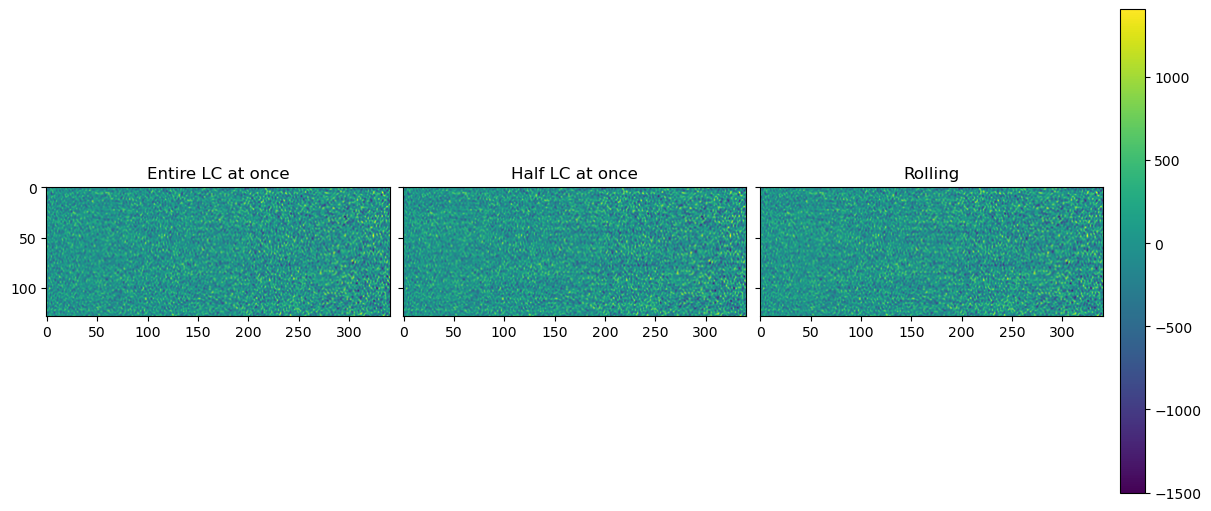

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

vmin= min(lc_wedge_removed_chunks[0, 0].min(), lc_wedge_removed_chunks_half[0, 0].min(), lc_wedge_removed_rolling[0, 0].min()).value
vmax= min(lc_wedge_removed_chunks[0, 0].max(), lc_wedge_removed_chunks_half[0, 0].max(), lc_wedge_removed_rolling[0, 0].max()).value

ax[0].imshow(lc_wedge_removed_chunks[0, 0].value, vmin=vmin, vmax=vmax)
ax[0].set_title("Entire LC at once")

ax[1].imshow(lc_wedge_removed_chunks_half[0, 0].value, vmin=vmin, vmax=vmax)
ax[1].set_title("Half LC at once")

im = ax[2].imshow(lc_wedge_removed_rolling[0, 0].value, vmin=vmin, vmax=vmax)
ax[2].set_title("Rolling")

plt.colorbar(im, ax=ax[2])

Text(0.5, 1.0, 'Rolling - Full')

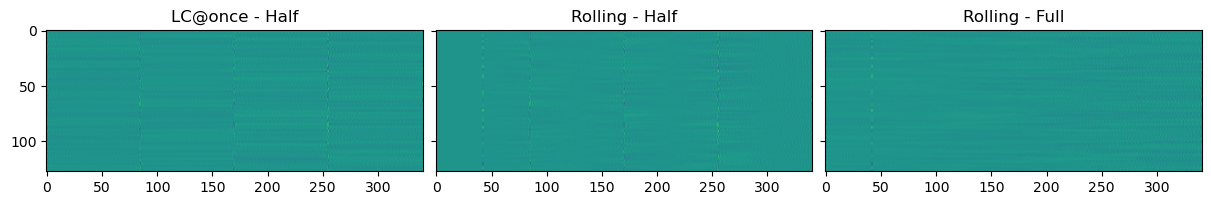

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

ax[0].imshow(lc_wedge_removed_chunks[0, 0].value - lc_wedge_removed_chunks_half.value[0,0], vmin=vmin, vmax=vmax)
ax[0].set_title("LC@once - Half")

ax[1].imshow(lc_wedge_removed_rolling[0, 0].value - lc_wedge_removed_chunks_half.value[0,0], vmin=vmin, vmax=vmax)
ax[1].set_title("Rolling - Half")

ax[2].imshow(lc_wedge_removed_rolling[0, 0].value - lc_wedge_removed_chunks.value[0,0], vmin=vmin, vmax=vmax)
ax[2].set_title("Rolling - Full")


Let's check the noise power spectrum.

In [34]:
from tuesday.core import calculate_ps_coeval,plot_power_spectrum
delta_noise = lc_noise[0].real - np.mean(lc_noise[0].real)

ps1d, ps2d = calculate_ps_coeval(
    delta_noise,
    box_length=boxlength,
    calc_2d=True,
    calc_1d=True,
    deltasq=False,
)


/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/powerbox/tools.py:287: RuntimeWarning: invalid value encountered in divide
  np.bincount(
/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/powerbox/tools.py:551: RuntimeWarning: invalid value encountered in divide
  np.bincount(
/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/powerbox/tools.py:732: UserWarning: One or more radial bins had no cells within it.
  return angular_average(


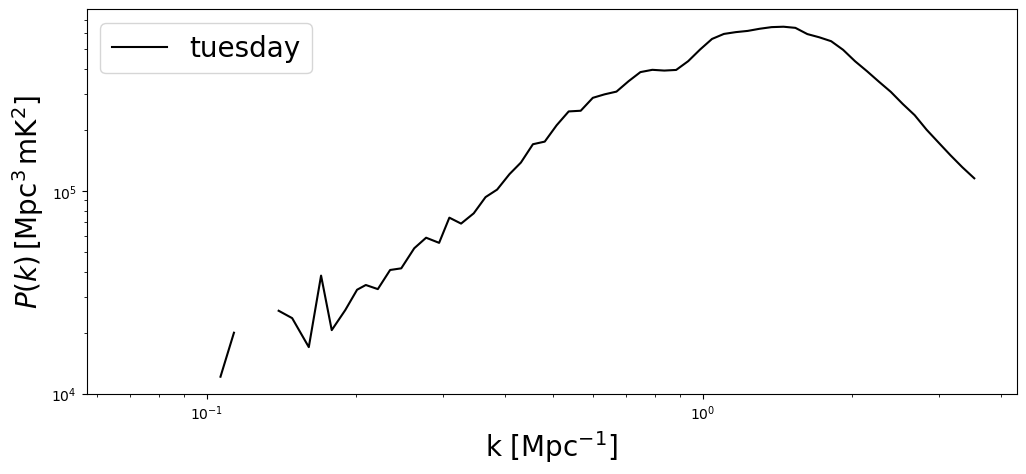

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax = plot_power_spectrum(
    ps1d,
    fontsize=20,
    ax=ax,
    color="k",
    legend="tuesday",
    logx=True,
    logy=True,
)

/home/yzhang/miniconda3/envs/21cmfast-v4/lib/python3.13/site-packages/astropy/units/quantity.py:1890: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)


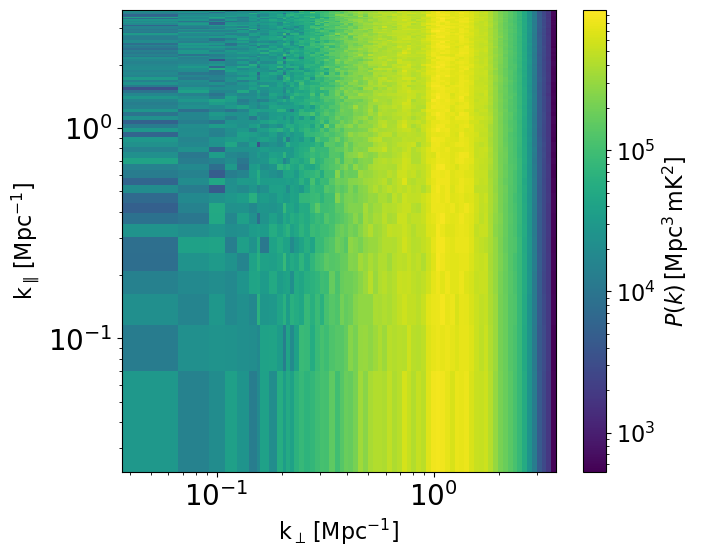

In [37]:
ax = plot_power_spectrum(
    ps2d,
    logx=True,
    logy=True,
    logc=True,
)